##  Random forest with the injected data set 

Use a Random forest trained on 80% of the data and then see how it performs on the remaining 20%.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

### Read in the data from Kelsey's file
Use Pandas to read in the csv file and give each column a name. 
Many of these are metrics calculated by Jason and Kelsey. There is a separate file explaining what they are.

In [2]:
ddir = "data/"
tcefile = "TESS_ML_20240412.txt"
columns = ["pass","win","type","injnum","period","tzero","power","dur","depth","snr","deptest1","deptest2",
           "stmass","stradius","chisq",
           "bicft","bicplus","bicminus","snrshape","noise","depth_shape2","depth_shape3","mindBIC",
           "nloops","npoints",
           "nintransit","26","27","28","29","30","31",
           "Tmag","Teff","logg","injrec","trprob"]
tces = pd.read_csv(ddir+tcefile, names=columns)

## Jason's Random Forest
Column trprob and injrec give the results of Jason's random forest.  Best to look at those to compare.
A value of 0.5 in trproj sholud be the same as the injrec results.

In [3]:
# This is how well Jason's RF runs written as a confusion matrix
#Originally Jason/Kelsey Confusion Matrix
injected = tces['injrec'] == 1

for prob in (0.2, 0.5, 0.8):
    jasonpassed = tces['trprob'] > prob  #This is arbitrary

    num00 = len(tces[~injected & ~jasonpassed])
    num01 = len(tces[~injected & jasonpassed])
    num10 = len(tces[injected & ~jasonpassed])
    num11 = len(tces[injected & jasonpassed])

    print("   ==>  For the Probability %f:" % prob)
    #print([num00,num01],"\n",[num10,num11])

    print(100*np.array([num00,num01])/(num00+num01),"\n",
          100*np.array([num10,num11])/(num10+num11))

   ==>  For the Probability 0.200000:
[99.10313901  0.89686099] 
 [ 1.03246598 98.96753402]
   ==>  For the Probability 0.500000:
[99.8745518  0.1254482] 
 [ 7.25113392 92.74886608]
   ==>  For the Probability 0.800000:
[9.99995319e+01 4.68090285e-04] 
 [17.25352113 82.74647887]


Jason got a 92% of the true positives to pass and 0.12% of the false positives to fail.

## My Random Forest
Start by using the netrics that Jason used.
Only some were used by Kelsey and Jason to vet, we will start with those for training,

In [6]:

metrics=[ #"period",
         "power","dur","depth","snr",
         #"deptest1","deptest2",
         "chisq",
         "bicft","bicplus","bicminus","snrshape","noise",
          "depth_shape2","depth_shape3",
         "mindBIC","nloops",
         #"npoints","nintransit",
         #"26","27","28","29","30","31",
         #"Tmag", "logg", "Teff"
         ]
#X contains the metrics that we will train and evalute on.
X = np.array(tces[metrics])
X[~np.isfinite(X)] = -9999

#Here we define the test and training sets using a routine written by Scikitlearn
X_train, X_test, y_train, y_test = train_test_split(X, tces['injrec'], test_size=0.2)
X_train[0]

array([1.7810000e-03, 5.0734500e-01, 7.4587000e-02, 2.1932127e+01,
       2.0000000e+00, 4.4703000e+02, 1.7540000e+02, 1.6324000e+02,
       1.7900000e+01, 1.9202000e-02, 3.1000000e+00, 3.3000000e+00,
       1.6324000e+02, 7.7000000e+01])

## Train the RF.
I found using n_estimators around 40 takes longer but gives significantly better results.

In [7]:
rf = RandomForestClassifier(n_estimators=40,max_depth=None, min_samples_split=2, random_state=0)
rf.fit(X_train, y_train)
scores= cross_val_score(rf, X_train, y_train, cv=6)
print("Cross Validation Score mean: %f" % scores.mean())

Cross Validation Score mean: 0.988650


## Make predictions for the Test set
The Test set was not used for training so these are entirely new.

Accuracy: 0.989322453231477
Test Set Only


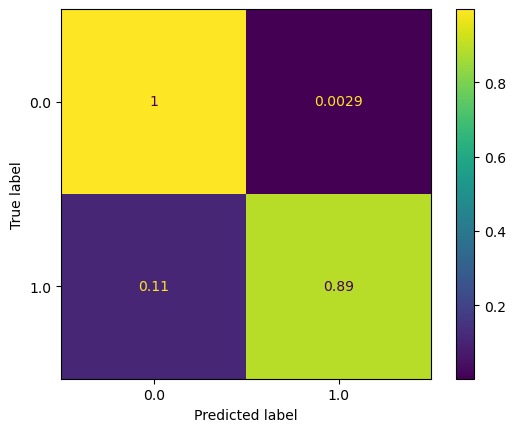

In [14]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_pred=y_pred, y_true = y_test)
print("Test Set Only")
_ = ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, normalize='true')
## _ = ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)

## Evaluate for the entire data set for direct comparison to Jason

Accuracy: 0.9977776813229741


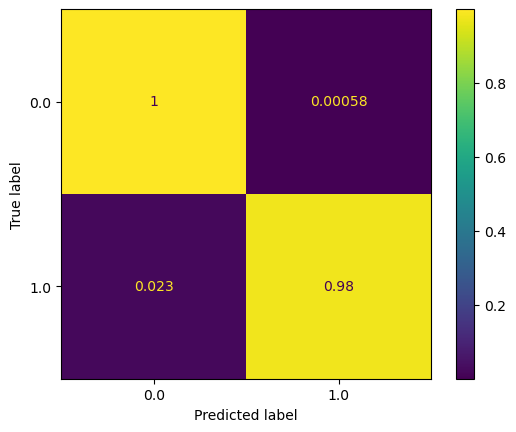

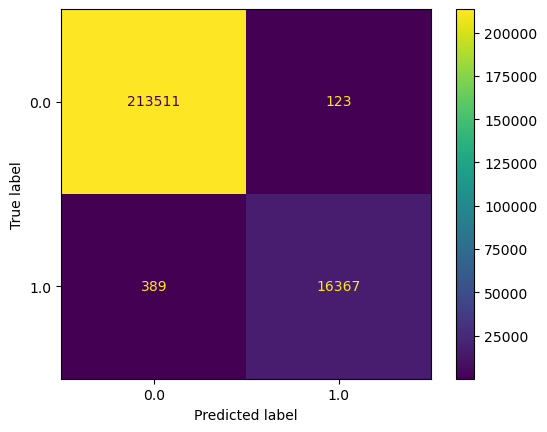

In [13]:
y_pred = rf.predict(X)
accuracy = accuracy_score(tces['injrec'], y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_pred=y_pred, y_true = tces['injrec'])

_ = ConfusionMatrixDisplay.from_estimator(rf, X, tces['injrec'], normalize='true')
_ = ConfusionMatrixDisplay.from_estimator(rf, X, tces['injrec'])

## Compare and Improve

This appears to be only an 82% completeness and accuracy of 0.9801
Ways I tried to improve the training to get what I have above wihtout changing the metrics is the following:

- Max depth went from 4 --> None.  This greatly improved things to a 0.987 mean accuracy and only losing 4% of the  injected signals with true with less than 0.04% of false positives miscalssified.
- I tried increasing the number is split samples to 4, but seemed to make things a bit worse.
- I looked at n_estimators from 10 --> 20, this gave me significant improvement.No only missing 2.9% of the true positives and now 0.07% of the false positives misclassified. (39 s runtime)
- I doubled the number of classifiers again to 40. This got me to 2.4% and 0.073%.  so let's stop there with that one.

Let's now switch out the algorithm a bit.
DecisionTree Classifier and ExtraTreesClassifier might work better. So I try them below. There is not significant improvement at least shown in any of these ways of evaluating the forrest.

Even if only consider the precision and recall of the test sets, I do best form the Random forest.





## Run through other similar algorithms

Cross Validation Score mean: 0.981553
Accuracy: 0.9824862190199227
Precision: 0.873011, Recall: 0.887391


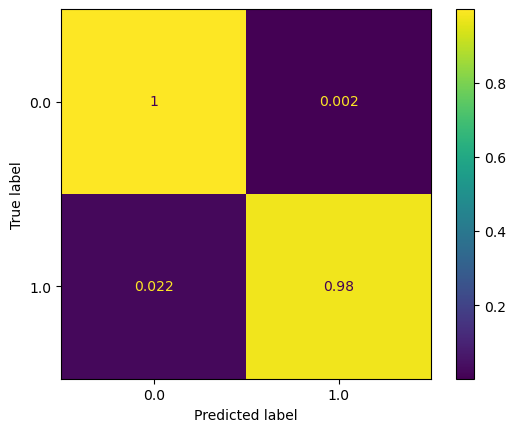

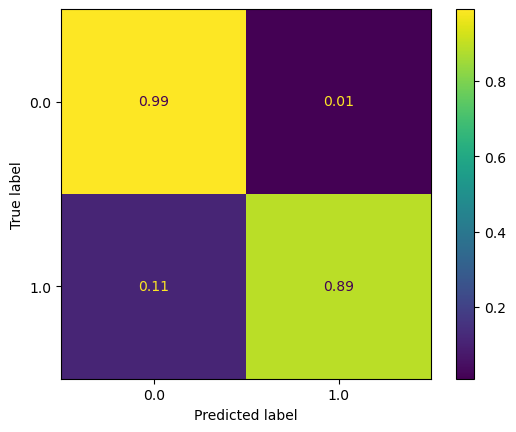

In [17]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

rf = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0)
rf.fit(X_train, y_train)
scores= cross_val_score(rf, X_train, y_train, cv=6)
print("Cross Validation Score mean: %f" % scores.mean())

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision: %f, Recall: %f" % (precision, recall))

cm = confusion_matrix(y_pred=y_pred, y_true = y_test)

_ = ConfusionMatrixDisplay.from_estimator(rf, X, tces['injrec'], normalize='true')
_ = ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, normalize='true')
#_ = ConfusionMatrixDisplay.from_estimator(rf, X, tces['injrec'])

Cross Validation Score mean: 0.987510
Accuracy: 0.9878900993966752
Precision: 0.955752, Recall: 0.873315


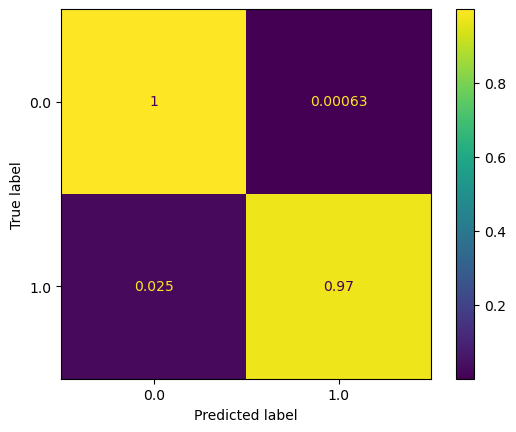

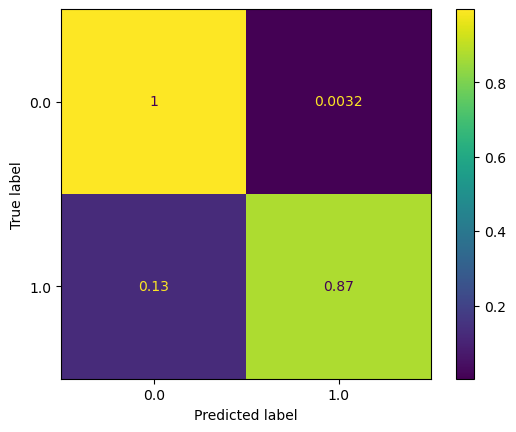

In [18]:
rf = ExtraTreesClassifier(n_estimators=40, max_depth=None, min_samples_split=2, random_state=0)
rf.fit(X_train, y_train)
scores= cross_val_score(rf, X_train, y_train, cv=6)
print("Cross Validation Score mean: %f" % scores.mean())

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision: %f, Recall: %f" % (precision, recall))

cm = confusion_matrix(y_pred=y_pred, y_true = y_test)

_ = ConfusionMatrixDisplay.from_estimator(rf, X, tces['injrec'], normalize='true')
_ = ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, normalize='true')
#_ = ConfusionMatrixDisplay.from_estimator(rf, X, tces['injrec'])

Cross Validation Score mean: 0.988585
Based on test set
Accuracy: 0.989192239246495
Precision: 0.957193, Recall: 0.890686


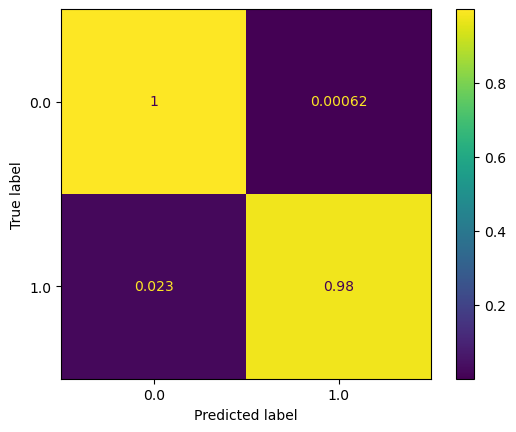

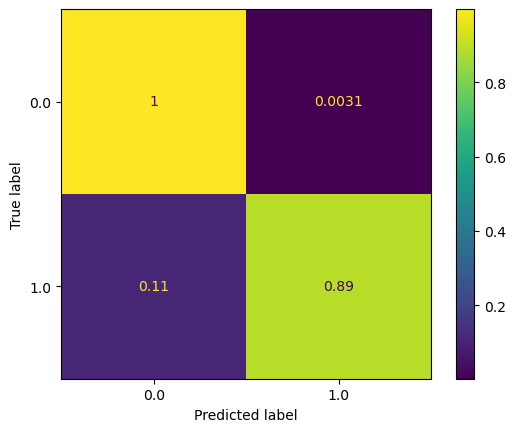

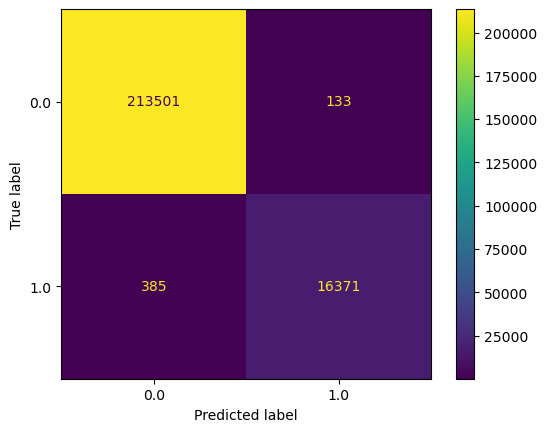

In [21]:

rf = RandomForestClassifier(n_estimators=40, max_depth=None, min_samples_split=2, random_state=2)
rf.fit(X_train, y_train)
scores= cross_val_score(rf, X_train, y_train, cv=6)
print("Cross Validation Score mean: %f" % scores.mean())

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Based on test set")
print("Accuracy:", accuracy)
print("Precision: %f, Recall: %f" % (precision, recall))

cm = confusion_matrix(y_pred=y_pred, y_true = y_test)

_ = ConfusionMatrixDisplay.from_estimator(rf, X, tces['injrec'], normalize='true')
_ = ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, normalize='true')
_ = ConfusionMatrixDisplay.from_estimator(rf, X, tces['injrec'])

## ROC and probability.
Receiver operator curve would be good to see as well.
Then we could also get an idea of confidence

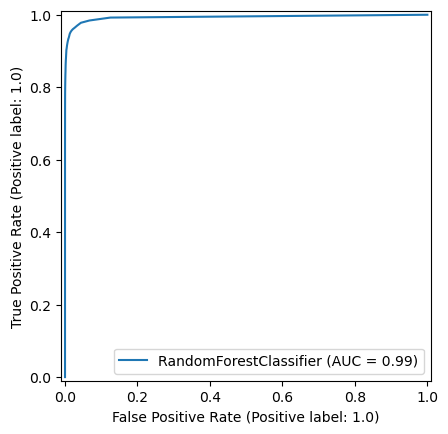

In [22]:
svc_disp = RocCurveDisplay.from_estimator(rf, X_test, y_test)
from sklearn.metrics import roc_auc_score


In [23]:
#Get probabilities
from sklearn.metrics import roc_auc_score
y_prob = rf.predict_proba(X)
y_test_prob = rf.predict_proba(X_test)
roc_auc_score(y_test, y_test_prob[:,1])

0.9931672054930517

In [24]:
#Record the results in the TCEs for the entire data set.
y_all = rf.predict(X)
y_prob = rf.predict_proba(X)

tces['newRF'] = y_all
tces['newRFprob'] = y_prob[:,1]  #Probability it is class "transit"

Text(0, 0.5, 'Susan Score')

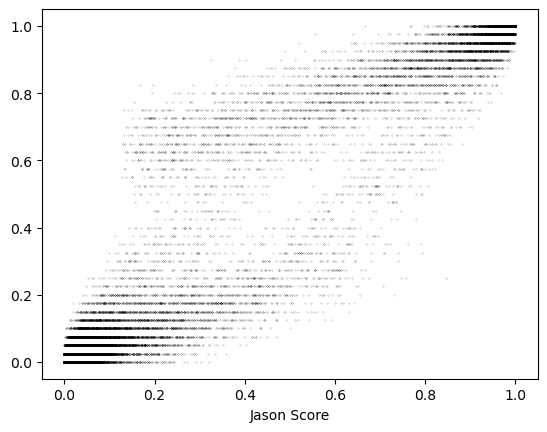

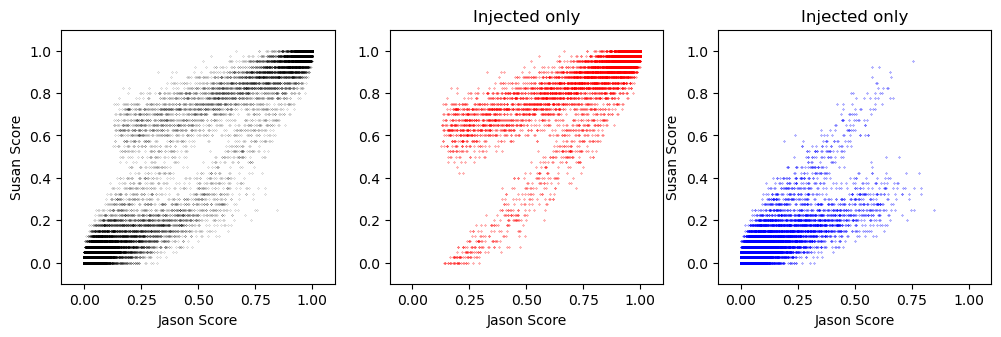

In [25]:
#Compare to Jason's RF for individual cases.
injected = tces['injrec'] == 1
jasonpassed = tces['trprob'] > 0.5
rfpassed = tces['newRFprob'] >0.5

plt.plot(tces['trprob'], tces['newRFprob'],'.k', ms=0.2)
plt.xlabel('Jason Score')#Compare to Jason's RF for individual cases.
injected = tces['injrec'] == 1
falsepos = tces['injrec'] == 0

plt.figure(figsize=(12,3.3))
plt.subplot(131)
plt.plot(tces['trprob'], tces['newRFprob'],'.k', ms=0.2)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.ylabel('Susan Score')
plt.subplot(132)
plt.plot(tces[injected]['trprob'],tces[injected]['newRFprob'], '.r',ms=0.5)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.title('Injected only')

plt.subplot(133)
plt.plot(tces[falsepos]['trprob'],tces[falsepos]['newRFprob'], '.b',ms=0.5)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.title('Injected only')
plt.tight_layout
plt.ylabel('Susan Score')

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

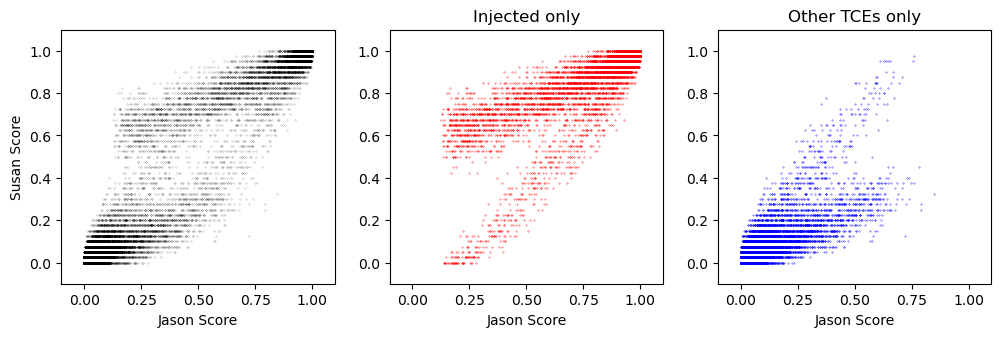

In [17]:
#Compare to Jason's RF for individual cases.
injected = tces['injrec'] == 1
falsepos = tces['injrec'] == 0

plt.figure(figsize=(12,3.3))
plt.subplot(131)
plt.plot(tces['trprob'], tces['newRFprob'],'.k', ms=0.2)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.ylabel('Susan Score')
plt.subplot(132)
plt.plot(tces[injected]['trprob'],tces[injected]['newRFprob'], '.r',ms=0.5)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.title('Injected only')

plt.subplot(133)
plt.plot(tces[falsepos]['trprob'],tces[falsepos]['newRFprob'], '.b',ms=0.5)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.title('Other TCEs only')
plt.tight_layout

## Compare the probability score with the binary score.
Does it just apply a threshold to determine the binary score.  Plotting 0,1 vs probability should show that.
Apparently a threshold of 0.5 in the probability score is the same as the binary result.

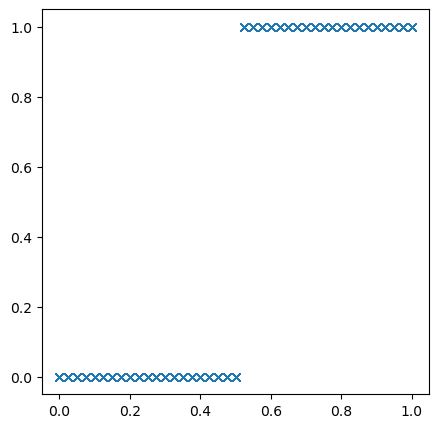

In [15]:
plt.figure(figsize=(5,5))
plt.plot(tces['newRFprob'], tces['newRF'],'x')

## Let's learn somethign about the ones I'm getting wrong.

In [26]:
tces.columns

Index(['pass', 'win', 'type', 'injnum', 'period', 'tzero', 'power', 'dur',
       'depth', 'snr', 'deptest1', 'deptest2', 'stmass', 'stradius', 'chisq',
       'bicft', 'bicplus', 'bicminus', 'snrshape', 'noise', 'depth_shape2',
       'depth_shape3', 'mindBIC', 'nloops', 'npoints', 'nintransit', '26',
       '27', '28', '29', '30', '31', 'Tmag', 'Teff', 'logg', 'injrec',
       'trprob', 'newRF', 'newRFprob'],
      dtype='object')

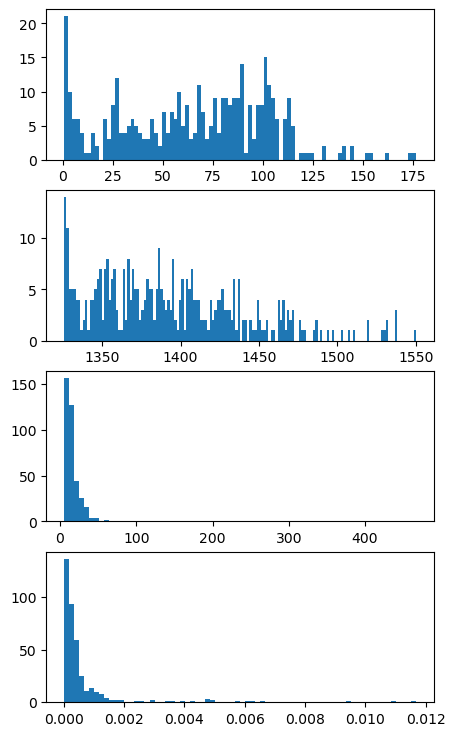

In [32]:
want = injected & ~rfpassed
extces = tces[want]

plt.figure(figsize=(5,9))
plt.subplot(4,1,1)
_,_,_ = plt.hist(extces['period'], 90)
plt.subplot(4,1,2)
_,_,_ = plt.hist(extces['tzero'], 150)
plt.subplot(4,1,3)
_,_,_ = plt.hist(extces['snr'], 70)
plt.subplot(4,1,4)
_,_,_ = plt.hist(extces['power'], 70)